# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [1]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Clean Britney playlist data

In [2]:
britney_df = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [3]:
britney_df =britney_df.drop_duplicates(subset='track_id')
britney_df.shape

(1193, 21)

In [4]:
britney_df = britney_df.dropna()
britney_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1189,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1190,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1191,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


### 2. Read training data 

In [5]:
genre_names = ["Jazz", "Pop", "Reggae", "Classical", "Country"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

Jazz
Pop
Reggae
Classical
Country


In [6]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((479, 7), (8856, 22))

In [7]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [8]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8852, 22)

In [9]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8746, 22)

<AxesSubplot:>

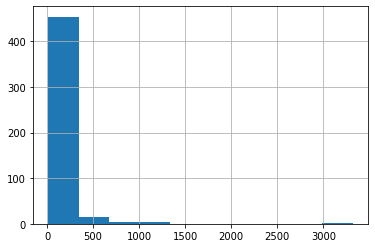

In [10]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

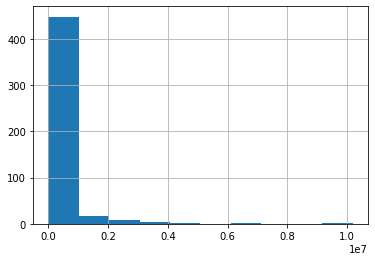

In [11]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [12]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

classical    0.272925
jazz         0.199634
pop          0.188772
reggae       0.186028
country      0.152641
Name: genre, dtype: float64

### 2. Refine the training data

In [13]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWVqfgj8NZEp1,Coffee Table Jazz,140,spotify,Spotify,2282279,jazz
1,37i9dQZF1DXbITWG1ZJKYt,Jazz Classics,100,spotify,Spotify,1905763,jazz
2,37i9dQZF1DX4wta20PHgwo,Late Night Jazz,80,spotify,Spotify,1852668,jazz
3,37i9dQZF1DX0SM0LYsmbMT,Jazz Vibes,350,spotify,Spotify,1775132,jazz
4,37i9dQZF1DWTbzY5gOVvKd,Jazzy Romance,60,spotify,Spotify,996283,jazz


In [14]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [15]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [16]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    2407.000000
mean        0.762869
std         0.174076
min         0.000000
25%         0.663653
50%         0.826147
75%         0.894885
max         1.000000
Name: loudness, dtype: float64

In [17]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()

count    2407.000000
mean        0.527422
std         0.154373
min         0.000000
25%         0.409178
50%         0.486401
75%         0.623485
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [18]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [19]:
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

In [20]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,2wOlZrHUpRP9hQbqbV9Ae5,Together,0Cioop2zjxXxtcPUme7R46,Matthew Halsall,1fcREbFQfCqfwxXkxGgvV7,672520,2009-10-26,61,0.401,0.0236,...,0.978,0.57900,0.1020,0.163,0.516468,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,11.208667,2
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,41sYqKPEygmvQrLXKpzWJU,167121,2020-04-17,62,0.327,0.1450,...,0.945,0.88400,0.0910,0.136,0.836329,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,2.785350,2
2,2R1vQwYTC0sl93C6oyVuHC,Simplicity,0FAC6FNPb4LsY5uyp0xTWF,Edward Simon,4GDYdHheKfIOBMjqOgTK6k,309586,2020-10-09,58,0.493,0.1070,...,0.881,0.90600,0.1220,0.126,0.426777,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,5.159767,2
3,7zzaZggdFuadOs0R7SuJlp,My Ideal,5CSkWcdoRvgBQDwJTZZstJ,Jerry Bergonzi,2T8WUL1jRlaGIqj36oD5O5,219766,2021-01-15,45,0.526,0.0767,...,0.802,0.00195,0.0978,0.247,0.526978,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,3.662767,2
4,7LIFp3v3CaTCvcG6fmceIg,Clouds,7c7414LKkYnuDPlkrwDg9a,Portraits in Jazz,3LEyIlY9P6z9Mvp6dpxk9d,283650,2020-11-27,56,0.338,0.1650,...,0.977,0.31500,0.1220,0.174,0.356400,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,4.727500,2


In [21]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'jazz', 3: 'pop', 4: 'reggae', 0: 'classical', 1: 'country'}

## 4. Train a KNN model

In [22]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


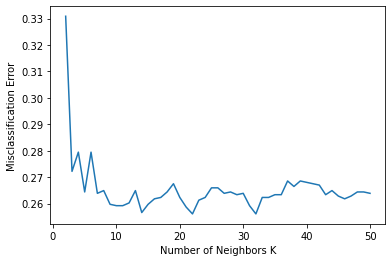

The optimal number of neighbors is 32 with score 74%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


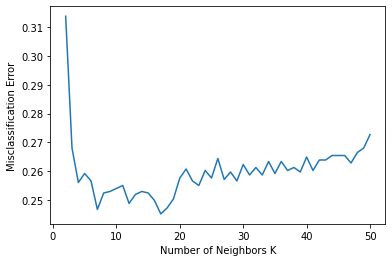

The optimal number of neighbors is 17 with score 75%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


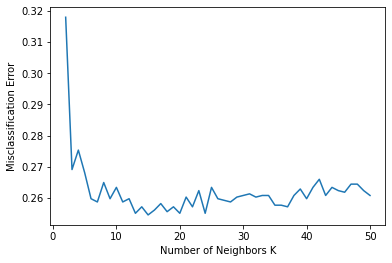

The optimal number of neighbors is 15 with score 74%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


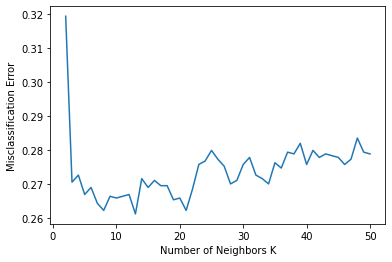

The optimal number of neighbors is 13 with score 73%


In [23]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [24]:
results_optimal_k

[32, 17, 15, 13]

### 5. Model Prediction

In [25]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [26]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [27]:
chart_tracks_df = chart_tracks_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 13


In [28]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
3335,2pn8dNVSpYnAtlKFC8Q0DJ,On The Ground,3eVa5w3URK5duf6eyVDbu9,ROSÉ,5BQcoDfcZ8aBcikYX9B7Ob,168085,2021-03-12,80,0.311,0.607,...,0.286,0.837618,3,pop,1.0,0.0,0.307692,0.000000,0.538462,0.153846
652,3xXBsjrbG1xQIm1xv1cKOt,One More Light,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,5Eevxp2BCbWq25ZdiXRwYd,255066,2017-05-19,72,0.593,0.200,...,0.170,0.193172,2,jazz,1.0,0.0,0.384615,0.000000,0.615385,0.000000
1483,2Uj9aeKOXPx4cgHrcd9401,Midnight Sky,30mZI7Hw2MhoarTVYxfyZM,Unique Salonga,2jBckVaJetRQeHQqgoLnh4,247968,2018-07-13,0,0.496,0.155,...,0.158,0.409887,2,jazz,1.0,0.0,0.076923,0.153846,0.538462,0.230769
393,60APt5N2NRaKWf5xzJdzyC,"Heatstroke (feat. Young Thug, Pharrell William...",7CajNmpbOovFoOoasH2HaY,Calvin Harris,2HaqChIDc5go3qxVunBDK0,229160,2017-06-30,59,0.784,0.728,...,0.713,0.354379,4,reggae,1.0,0.0,0.000000,0.000000,0.000000,1.000000
2753,47EWMOElkkbMp5m9SBkx7d,IDK You Yet,6sFHvCyqklnJpXC9Nh1aag,Alexander 23,2BcmdSV1kyss7KFuSpobeS,184638,2020-04-09,51,0.629,0.306,...,0.191,0.150273,2,jazz,1.0,0.0,0.461538,0.153846,0.384615,0.000000


Check out tracks with highest assigned probability

In [29]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
3335,ROSÉ,On The Ground,pop,1.000000
652,Linkin Park,One More Light,jazz,1.000000
1483,Unique Salonga,Midnight Sky,jazz,1.000000
393,Calvin Harris,"Heatstroke (feat. Young Thug, Pharrell William...",reggae,1.000000
2753,Alexander 23,IDK You Yet,jazz,1.000000
3276,Ariana Grande,"34+35 Remix (feat. Doja Cat, Megan Thee Stalli...",reggae,1.000000
3285,Jeremy Zucker,this is how you fall in love,jazz,1.000000
547,Calvin Harris,Rollin (feat. Future & Khalid),reggae,1.000000
3079,Moira Dela Torre,Paubaya,jazz,1.000000
2698,Megan Thee Stallion,Savage Remix (feat. Beyoncé),reggae,1.000000


View histogram of predicted genre probabilities

<AxesSubplot:>

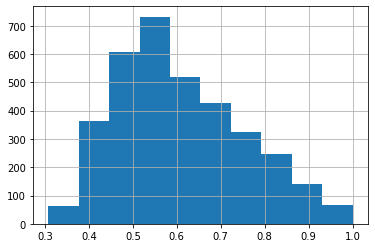

In [30]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [31]:
chart_tracks_df['predicted_genre'].value_counts()

pop          1348
reggae        968
country       631
jazz          523
classical      19
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [32]:
this_song = 'Lay Me Down'
chart_tracks_df[chart_tracks_df['track_name'].str.contains('Lay Me Down')]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
762,64GRDrL1efgXclrhVCeuA0,Lay Me Down,2wY79sveU1sp5g7SokKOiI,Sam Smith,0vrWqbRQEMKqhTGcDLQK7x,219535,2015-11-06,75,0.468,0.19,...,0.326,0.447624,2,jazz,0.923077,0.0,0.076923,0.0,0.384615,0.538462


In [33]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [34]:
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
3335,2pn8dNVSpYnAtlKFC8Q0DJ,On The Ground,3eVa5w3URK5duf6eyVDbu9,ROSÉ,5BQcoDfcZ8aBcikYX9B7Ob,168085,2021-03-12,80,0.311,0.607,...,0.286,0.837618,3,pop,1.0,0.0,0.307692,0.000000,0.538462,0.153846
652,3xXBsjrbG1xQIm1xv1cKOt,One More Light,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,5Eevxp2BCbWq25ZdiXRwYd,255066,2017-05-19,72,0.593,0.200,...,0.170,0.193172,2,jazz,1.0,0.0,0.384615,0.000000,0.615385,0.000000
1483,2Uj9aeKOXPx4cgHrcd9401,Midnight Sky,30mZI7Hw2MhoarTVYxfyZM,Unique Salonga,2jBckVaJetRQeHQqgoLnh4,247968,2018-07-13,0,0.496,0.155,...,0.158,0.409887,2,jazz,1.0,0.0,0.076923,0.153846,0.538462,0.230769
393,60APt5N2NRaKWf5xzJdzyC,"Heatstroke (feat. Young Thug, Pharrell William...",7CajNmpbOovFoOoasH2HaY,Calvin Harris,2HaqChIDc5go3qxVunBDK0,229160,2017-06-30,59,0.784,0.728,...,0.713,0.354379,4,reggae,1.0,0.0,0.000000,0.000000,0.000000,1.000000
2753,47EWMOElkkbMp5m9SBkx7d,IDK You Yet,6sFHvCyqklnJpXC9Nh1aag,Alexander 23,2BcmdSV1kyss7KFuSpobeS,184638,2020-04-09,51,0.629,0.306,...,0.191,0.150273,2,jazz,1.0,0.0,0.461538,0.153846,0.384615,0.000000


In [35]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_country_prob',
       'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_reggae_prob'],
      dtype='object')

In [36]:
#read data
britney_df=pd.read_csv("data/Britney_Spears_playlist_tracks_data.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.713767,0,0.0307,0.2020,0.000131,0.4430,0.907,0.218504,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.807438,0,0.1140,0.0249,0.025000,0.2420,0.924,0.550393,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.729166,0,0.0437,0.3000,0.000018,0.3550,0.894,0.232375,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,0.740318,1,0.0622,0.0730,0.000000,0.0889,0.235,0.523619,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,0.847496,1,0.0334,0.2500,0.000678,0.0723,0.382,0.353460,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [37]:
# Input seed track here
seed_track_name = 'Oops!...I Did It Again'

In [38]:
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

In [39]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[feature_cols]

In [40]:
seed_track_data = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
scaler = MinMaxScaler()
seed_track_data['loudness'] = scaler.fit_transform(seed_track_data[['loudness']])
seed_track_data['tempo'] =  scaler.fit_transform(seed_track_data[['tempo']])
#seed_track_data = seed_track_data[feature_cols].iloc[1]
seed_track_data = seed_track_data[feature_cols].mean()
seed_track_data

danceability        0.666693
energy              0.728810
loudness            0.725647
speechiness         0.080287
acousticness        0.136064
instrumentalness    0.011355
liveness            0.182987
valence             0.600610
tempo               0.392383
dtype: float64

In [41]:
#seed_track_data['track_id'] = '6naxalmIoLFWR0siv8dnQQ'
#seed_track_data

In [42]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [66]:
chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('euclidean_dist')[:10]
recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

,track_name,artist_name,euclidean_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2958,you broke me first,Tate McRae,0.000307,jazz,0.667,0.373,0.608434,0.0500,0.78500,0.000000,0.0906,0.0823,0.440419
2825,Maria,Hwa Sa,0.000307,reggae,0.667,0.745,0.871648,0.0621,0.23800,0.000002,0.2550,0.4820,0.470102
31,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,0.000307,pop,0.667,0.830,0.758854,0.0749,0.01230,0.000000,0.1910,0.7010,0.372008
777,MIC Drop,BTS,0.000307,pop,0.667,0.889,0.794227,0.0918,0.00912,0.000000,0.0816,0.5410,0.722302
2613,In Your Eyes,The Weeknd,0.000307,pop,0.667,0.719,0.772938,0.0346,0.00285,0.000081,0.0736,0.7170,0.291962
73,One Call Away,Charlie Puth,0.000307,country,0.667,0.613,0.773675,0.0344,0.40300,0.000000,0.1150,0.4700,0.236601
1188,Everyday,Logic,0.000307,pop,0.667,0.741,0.825015,0.0378,0.04250,0.000000,0.0761,0.4220,0.598924
2301,Graveyard,Halsey,0.000307,pop,0.667,0.583,0.782927,0.0747,0.23100,0.000045,0.1810,0.1870,0.242872
398,TG4M,Zara Larsson,0.000307,pop,0.667,0.648,0.730890,0.0626,0.02350,0.000015,0.0427,0.5890,0.261257
2438,My Only Wish (This Year),Britney Spears,0.000693,country,0.666,0.824,0.798649,0.0267,0.17500,0.000000,0.2050,0.6980,0.581425


In [68]:
chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('manhattan_dist')[:10]
recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

,track_name,artist_name,manhattan_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2958,you broke me first,Tate McRae,0.000307,jazz,0.667,0.373,0.608434,0.0500,0.78500,0.000000,0.0906,0.0823,0.440419
2825,Maria,Hwa Sa,0.000307,reggae,0.667,0.745,0.871648,0.0621,0.23800,0.000002,0.2550,0.4820,0.470102
31,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,0.000307,pop,0.667,0.830,0.758854,0.0749,0.01230,0.000000,0.1910,0.7010,0.372008
777,MIC Drop,BTS,0.000307,pop,0.667,0.889,0.794227,0.0918,0.00912,0.000000,0.0816,0.5410,0.722302
2613,In Your Eyes,The Weeknd,0.000307,pop,0.667,0.719,0.772938,0.0346,0.00285,0.000081,0.0736,0.7170,0.291962
73,One Call Away,Charlie Puth,0.000307,country,0.667,0.613,0.773675,0.0344,0.40300,0.000000,0.1150,0.4700,0.236601
1188,Everyday,Logic,0.000307,pop,0.667,0.741,0.825015,0.0378,0.04250,0.000000,0.0761,0.4220,0.598924
2301,Graveyard,Halsey,0.000307,pop,0.667,0.583,0.782927,0.0747,0.23100,0.000045,0.1810,0.1870,0.242872
398,TG4M,Zara Larsson,0.000307,pop,0.667,0.648,0.730890,0.0626,0.02350,0.000015,0.0427,0.5890,0.261257
2438,My Only Wish (This Year),Britney Spears,0.000693,country,0.666,0.824,0.798649,0.0267,0.17500,0.000000,0.2050,0.6980,0.581425


In [67]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

chart_tracks_df.sort_values(by='cosine_dist',ascending=False).head()

#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
674,Sharp Edges,Linkin Park,0.001085,country,0.652,0.714,0.760368,0.0562,0.1450,0.000000,0.154,0.624,0.365849
1331,134340,BTS,0.002216,country,0.664,0.688,0.728106,0.0543,0.1530,0.000091,0.173,0.650,0.328887
2324,Cry for Me,Camila Cabello,0.002802,reggae,0.721,0.805,0.823582,0.0927,0.0500,0.000000,0.153,0.653,0.402946
3017,Diamonds,Sam Smith,0.002998,country,0.653,0.667,0.715906,0.0423,0.1540,0.000000,0.107,0.556,0.317559
3134,Diamonds,Sam Smith,0.003096,country,0.637,0.666,0.715537,0.0494,0.1610,0.000000,0.108,0.529,0.316568
3361,LILAC,IU,0.003225,reggae,0.738,0.890,0.899693,0.0748,0.0895,0.000002,0.213,0.750,0.383773
2099,Do You Mean (feat. Ty Dolla $ign & bülow),The Chainsmokers,0.003297,country,0.600,0.666,0.590502,0.0394,0.1020,0.000000,0.118,0.566,0.291765
3122,motive (with Doja Cat),Ariana Grande,0.003310,reggae,0.789,0.742,0.760942,0.0652,0.0681,0.000000,0.166,0.661,0.396221
2312,TRICK IT,TWICE,0.003405,reggae,0.756,0.897,0.829150,0.0780,0.0895,0.000017,0.140,0.619,0.464355
279,Believer,Imagine Dragons,0.003413,reggae,0.779,0.787,0.816581,0.1080,0.0524,0.000000,0.140,0.708,0.445551


array([[<AxesSubplot:title={'center':'euclidean_dist'}>,
        <AxesSubplot:title={'center':'manhattan_dist'}>],
       [<AxesSubplot:title={'center':'cosine_dist'}>, <AxesSubplot:>]],
      dtype=object)

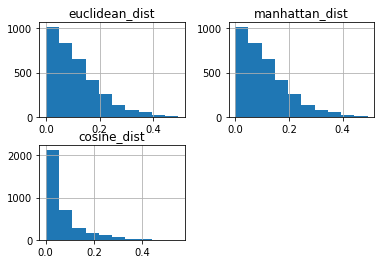

In [69]:
chart_tracks_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

Modify similarity criteria

In [139]:
collab_cosine = chart_tracks_df.sort_values('cosine_dist', ascending=True).head(10)
collab_cosine.artist_name
#collab_cosine.groupby('artist_name').size().sort_values(ascending=False)

674          Linkin Park
1331                 BTS
2324      Camila Cabello
3017           Sam Smith
3134           Sam Smith
3361                  IU
2099    The Chainsmokers
3122       Ariana Grande
2312               TWICE
279      Imagine Dragons
Name: artist_name, dtype: object

In [146]:
#For filtering artists only
top_artists = pd.read_csv("data/spotify_daily_charts.csv")
top_artists['date'] = pd.to_datetime(top_artists['date'])
top_artists['year']= top_artists['date'].dt.year
yearly = top_artists[top_artists['position']<=50]

Index(['date', 'position', 'track_id', 'track_name', 'artist', 'streams',
       'year'],
      dtype='object')

In [160]:
#Filtering Artists
#ave streams = 107,264

#yearly[yearly['artist']=='Linkin Park'] # --- FAILED = top on year 2017 only
#yearly[yearly['artist']=='Linkin Park']['streams'].mean() # --- FAILED = 70136.72727272728 ave streams only

#yearly[yearly['artist']=='BTS'] # --- PASSED
#yearly[yearly['artist']=='BTS']['streams'].mean() # --- ave streams = 134090.87023593465

#yearly[yearly['artist']=='Camila Cabello'] # --- PASSED
#yearly[yearly['artist']=='Camila Cabello']['streams'].mean() # --- ave streams = 112520.33220910624

#yearly[yearly['artist']=='Sam Smith'] # --- PASSED
#yearly[yearly['artist']=='Sam Smith']['streams'].mean() # --- ave streams = 120574.13819095478

#FINAL 3 COLLABORATORS (ARTISTS WITH DIFFERENT GENRE --- LOWEST COSINE DISTANCE)
#1. BTS
#2. Camila Cabello
#3. Sam Smith

,date,position,track_id,track_name,artist,streams,year
39607,2017-07-21,8,60a0Rd6pjrkxjPbaKzXjfq,In the End,Linkin Park,113191,2017
39623,2017-07-21,24,104buTcnP2AsxqB7U1FIZ4,Heavy (feat. Kiiara),Linkin Park,91694,2017
39624,2017-07-21,25,2nLtzopw4rPReszdYBJU6h,Numb,Linkin Park,91682,2017
39642,2017-07-21,43,4kfm1uI9QGaoN9qm6CkAMn,What I've Done,Linkin Park,63807,2017
39644,2017-07-21,45,1yFiaFeSLpw4nDYTeErRZ6,Leave Out All The Rest,Linkin Park,63504,2017
39649,2017-07-21,50,1Vej0qeQ3ioKwpI6FUbRv1,Papercut,Linkin Park,58740,2017
39834,2017-07-22,35,60a0Rd6pjrkxjPbaKzXjfq,In the End,Linkin Park,67677,2017
39847,2017-07-22,48,104buTcnP2AsxqB7U1FIZ4,Heavy (feat. Kiiara),Linkin Park,56099,2017
40044,2017-07-23,45,60a0Rd6pjrkxjPbaKzXjfq,In the End,Linkin Park,57862,2017
40047,2017-07-23,48,104buTcnP2AsxqB7U1FIZ4,Heavy (feat. Kiiara),Linkin Park,52385,2017


In [143]:
collab_manhattan = chart_tracks_df.sort_values('manhattan_dist', ascending=True).head(10)
collab_manhattan.artist_name

#NOT RELIABLE --- BRITNEY SPEARS HERSELF IS AT THE BOTTOM 10

2958           Tate McRae
2825               Hwa Sa
31      Justin Timberlake
777                   BTS
2613           The Weeknd
73           Charlie Puth
1188                Logic
2301               Halsey
398          Zara Larsson
2438       Britney Spears
Name: artist_name, dtype: object

In [138]:
collab_euclidean = chart_tracks_df.sort_values('euclidean_dist', ascending=True).head(10)
collab_euclidean.artist_name

#NOT RELIABLE --- BRITNEY SPEARS HERSELF IS AT THE BOTTOM 10

2958           Tate McRae
2825               Hwa Sa
31      Justin Timberlake
777                   BTS
2613           The Weeknd
73           Charlie Puth
1188                Logic
2301               Halsey
398          Zara Larsson
2438       Britney Spears
Name: artist_name, dtype: object

In [156]:
#prediction = chart_tracks_df.sort_values('cosine_dist')
#prediction.groupby('predicted_genre')['popularity'].mean().sort_values(ascending=False)

predicted_genre
jazz         49.277247
country      48.456418
reggae       48.133264
pop          47.956231
classical    41.210526
Name: popularity, dtype: float64